# Damage Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02d import *

### Data

In [3]:
#export
CATS = ['nun', 'minor', 'major', 'destroyed']

In [4]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/images')]

In [5]:
annots = pd.read_csv('class_labels_combined_gpu.csv')

In [6]:
annots.shape

(94313, 4)

In [7]:
annots = annots.sample(len(annots))

In [8]:
annots.damage.value_counts()

minor        25724
nun          23578
destroyed    23562
major        21449
Name: damage, dtype: int64

In [9]:
fnames = list(annots.file)
fnames[:3]

['data/tier3/classification_images/8a89a4dd-9abf-4aa3-bcfd-ce89a893e26d.png',
 'data/train/classification_images/cbcaa8e3-e82d-4df0-bb60-2ee3ad7e5025.png',
 'data/tier3/classification_images/6406b6b7-f3b2-419c-a5cc-6bef81c58ddb.png']

### LabeledData

In [10]:
val_idx = get_random_val_idx(len(fnames), val_pct=.2)

In [11]:
%%time
_dict_file2damage = {f:d for f,d in zip(annots.file, annots.damage)}

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 50.9 ms


In [12]:
#export
def get_label(fname): return _dict_file2damage[fname]

In [13]:
%%time
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(get_label, classes=CATS))

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 102 ms


In [14]:
src

LabelLists;

Train: LabelList (75451 items)
x: ImageList
Image (3, 55, 58),Image (3, 19, 19),Image (3, 103, 117),Image (3, 90, 81),Image (3, 139, 91)
y: CategoryList
minor,destroyed,destroyed,minor,major
Path: .;

Valid: LabelList (18862 items)
x: ImageList
Image (3, 104, 84),Image (3, 64, 113),Image (3, 173, 208),Image (3, 48, 45),Image (3, 104, 91)
y: CategoryList
nun,nun,nun,major,destroyed
Path: .;

Test: None

### Training

In [15]:
bs = 32
sz = 299 #64 #512
tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [16]:
#idx = 18
#data.valid_ds.x[idx].show()
#print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

In [17]:
#data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [18]:
cb_funcs = [partial(callbacks.SaveModelCallback, monitor='error_rate', mode='min', every='improvement', name='best_model'),]
metrics = [error_rate, FBeta(average='weighted')]
learn = cnn_learner(data, models.resnet152, metrics=metrics, loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=cb_funcs, wd=1e-3, bn_wd=False, true_wd=True, ps=0.).mixup(alpha=.2)

In [58]:
#learn.to_fp16(dynamic=True);

In [19]:
learn.load('best_model_damg_nsample42000_sz299_bs32_resnet152');

In [20]:
learn.export('best_model_damg_nsample42000_sz299_bs32_resnet152.pkl');

In [59]:
learn.load('best_model_damg_nsample42000_sz299_bs32_resnet152');

In [61]:
learn.unfreeze()

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


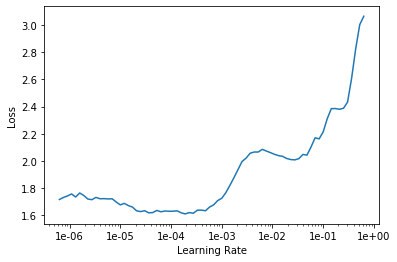

In [63]:
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(cyc_len=20, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,1.522005,0.975263,0.169388,0.830748,32:18
1,1.393096,0.911077,0.185134,0.815238,32:19
2,1.253522,0.862017,0.205440,0.795000,32:14
3,1.127567,0.827087,0.219913,0.780558,32:22
4,1.051405,0.796260,0.219701,0.780392,32:23
5,1.015781,0.782260,0.219277,0.780826,32:16
6,0.966557,0.770175,0.215566,0.784492,32:22
7,0.956556,0.763062,0.214611,0.785179,32:23
8,0.957408,0.754638,0.211908,0.787820,32:27
9,0.957869,0.754449,0.212226,0.787413,32:30


Better model found at epoch 0 with error_rate value: 0.16938818991184235.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

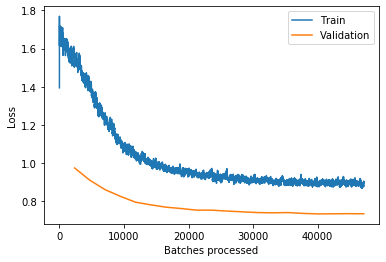

In [65]:
learn.recorder.plot_losses()

In [66]:
learn.save('20epochs_model_damg_nsample94313_sz299_bs32_resnet152_tfms_mixup_labsmooth_wd')

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


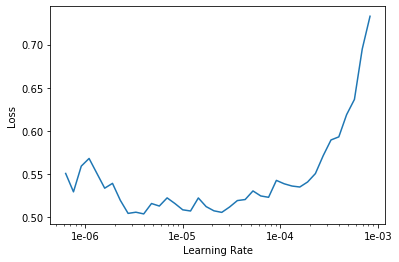

In [33]:
learn.recorder.plot()

In [90]:
learn.export('damage_classifier.pkl')

### Classification results

best_model_damg_nsample10000_sz299_bs32_resnet152 ----- 4 	1.027053 	1.055706 	0.275000 	0.725237 	03:25
best_model_damg_nsample10000_sz299_bs32_resnet152_tfms_mixup_labelsmooth ----- 5 	0.973839 	0.910530 	0.305500 	0.693718 	03:26

best_model_damg_nsample30000_sz299_bs32_resnet152  ---- 4 	0.497787 	0.636151 	0.203833 	0.796178 	10:11

best_model_damg_nsample36000_sz299_bs32_resnet152 ----- 0 	0.588692 	0.509510 	0.161528 	0.838523 	12:13

**best_model_damg_nsample42000_sz299_bs32_resnet152** ----- 0 	0.560124 	0.495904 	0.155952 	0.843830 	14:18

best_model_damg_nsample55000_sz299_bs32_resnet152 ----- 0 	0.545310 	0.468869 	0.158727 	0.841003 	13:51

best_model_damg_nsample94313_sz299_bs32_resnet152 ----- 0 	0.550715 	0.473009 	0.158255 	0.841745 	23:57

best_model_damg_nsample94313_sz299_bs32_resnet152_tfms_mixup_labsmooth_wd ----- 0 	1.522005 	0.975263 	0.169388 	0.830748 	32:18

20epochs_model_damg_nsample94313_sz299_bs32_resnet152_tfms_mixup_labsmooth_wd ----- 19 	0.897858 	0.735694 	0.203425 	0.796434 	32:06

best_model_damg_nsample55000_sz224_bs64_resnet152_fp16 ----- 0 	0.323151 	0.612834 	0.230909 	0.768898 	10:36

1. classifier_maxsz128_sz32_bs64_resnet50_tfmsNone_stage1 ----- 39 	0.758440 	1.137212 	0.382500 	00:05
2. classifier_maxsz128_sz32_bs64_resnet50_tfmsNone_stage2 ----- 39 	0.643406 	1.045906 	0.390000 	00:06

1. classifier_maxsz128_sz64_bs32_resnet50_tfmsNone_stage1 ----- 39 	0.640366 	1.002563 	0.320000 	00:09
2. classifier_maxsz128_sz64_bs32_resnet50_tfmsNone_stage1 ----- 39 	0.520865 	0.978961 	0.331250 	00:12

1. classifier_maxsz128_sz128_bs16_resnet50_tfmsNone_stage1 -- 39 	0.730958 	0.760683 	0.267500 	00:50
2. classifier_maxsz128_sz128_bs16_resnet50_tfmsNone_stage2 -- 9 	0.554020 	0.782075 	0.280500 	01:03

1. classifier_sz64_bs16_resnet50_stage1 ----- 19 	0.887879 	0.600300 	0.237990 	00:45
2. classifier_sz64_bs16_resnet50_stage2 ----- 19 	0.818543 	0.574872 	0.229120 	00:58
3. classifier_sz128_bs16_resnet50_stage1 ---- 19 	0.890955 	0.617753 	0.235772 	00:46


1. classifier_sz128_bs64_resnet50_stage1 ----- 19 	0.794813 	0.513871 	0.188470 	00:18

1. classifier_sz128_bs64_resnet101_stage1 ----- 19 	0.885585 	0.722650 	0.237251 	00:31
2. classifier_sz128_bs64_resnet101_stage2 ----- 39 	0.813070 	0.773460 	0.201774 	00:44

1. classifier_sz128_bs64_resnet101_tfmsNone_stage1 ----- 19 	0.595315 	0.578356 	0.201774 	00:31
2. classifier_sz128_bs64_resnet101_tfmsNone_stage2 ----- 39 	0.459314 	0.549257 	0.187731 	00:44

1. classifier_sz256_bs64_resnet101_tfmsNone_stage1 ----- 29 	0.515034 	0.652625 	0.205469 	01:37


### Results interpretation

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

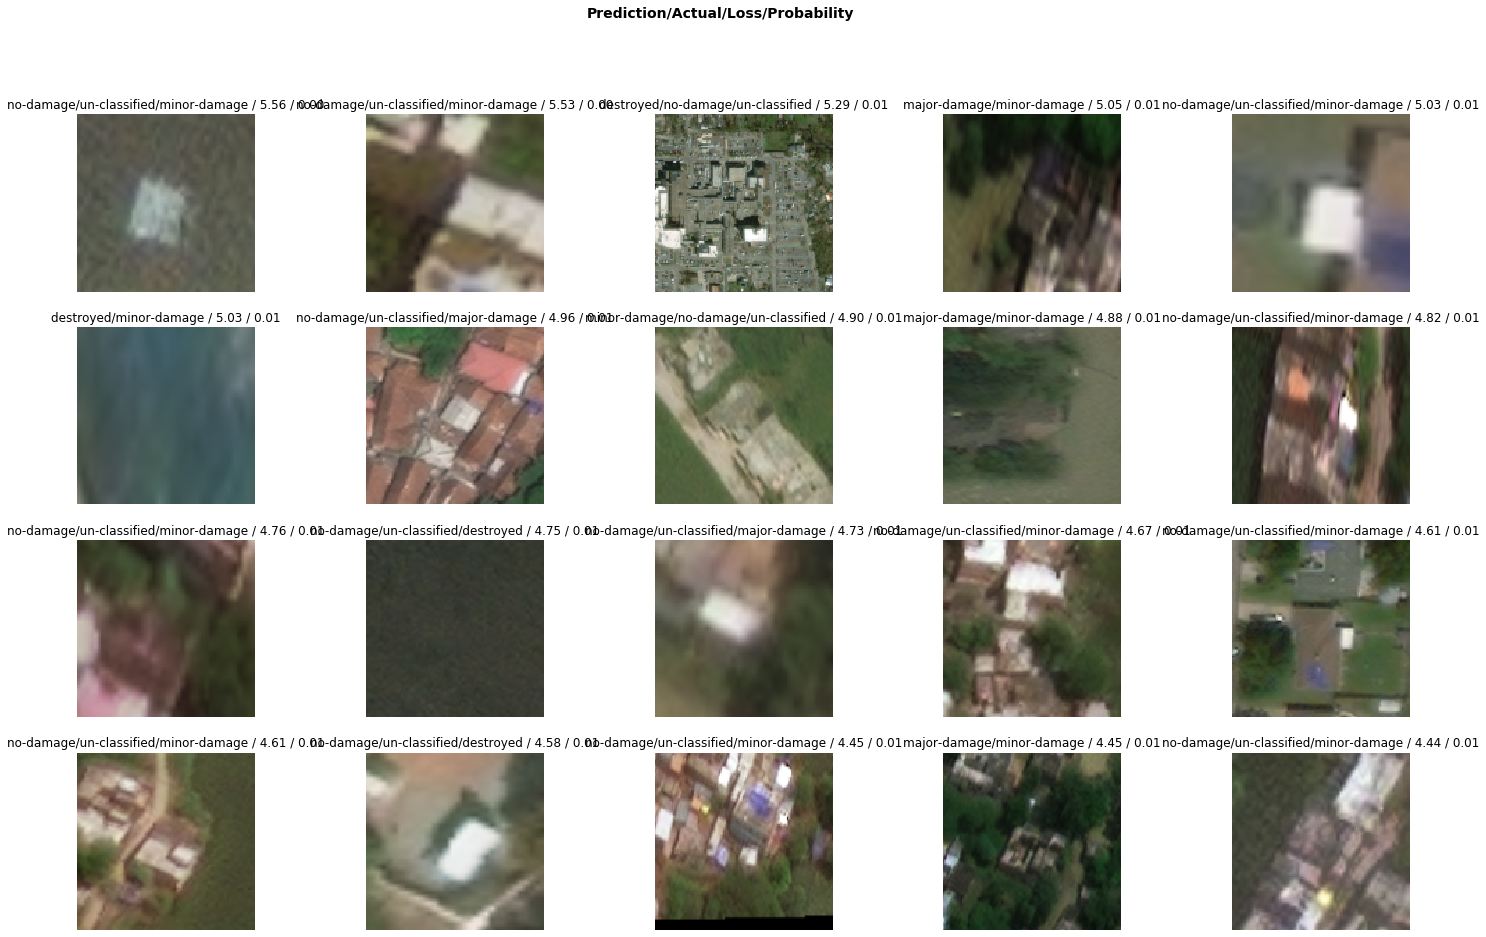

In [30]:
interp.plot_top_losses(20, figsize=(25, 15))

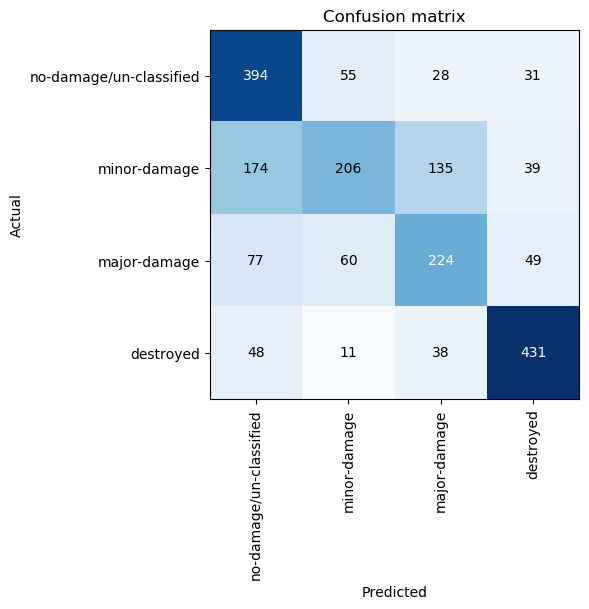

In [32]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=100)

In [33]:
interp.most_confused(min_val=2)

[('minor-damage', 'no-damage/un-classified', 174),
 ('minor-damage', 'major-damage', 135),
 ('major-damage', 'no-damage/un-classified', 77),
 ('major-damage', 'minor-damage', 60),
 ('no-damage/un-classified', 'minor-damage', 55),
 ('major-damage', 'destroyed', 49),
 ('destroyed', 'no-damage/un-classified', 48),
 ('minor-damage', 'destroyed', 39),
 ('destroyed', 'major-damage', 38),
 ('no-damage/un-classified', 'destroyed', 31),
 ('no-damage/un-classified', 'major-damage', 28),
 ('destroyed', 'minor-damage', 11)]

### Infer on single image

In [101]:
idx = 15
img = open_image(data.valid_ds.items[idx])

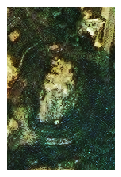

In [102]:
img.show()

In [103]:
learn.predict(img)

(Category destroyed, tensor(3), tensor([0.0191, 0.0238, 0.0128, 0.9443]))

### Infer on 10 images

In [87]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [88]:
uids = [o.stem for o in list(data.valid_ds.items[:10])]

In [89]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer single image (`load_learner`)

In [92]:
load_learn = load_learner('./', file='damage_classifier.pkl')

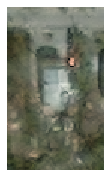

In [96]:
idx = 15
img = open_image(data.valid_ds.items[idx])
img.show()

In [97]:
load_learn.predict(img)

(Category no-damage/un-classified,
 tensor(0),
 tensor([0.8909, 0.0076, 0.0885, 0.0130]))

### Infer on 10 images (`load_learner`)

In [98]:
load_learn = load_learner('./', file='damage_classifier.pkl')

In [99]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = load_learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [101]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer 10 images (`load_learner` and `get_preds`)

In [105]:
il = ImageList(data.valid_ds.items[:10])

In [106]:
load_learn = load_learner('./', file='damage_classifier.pkl', test=il)

In [107]:
pred_damg, y_damg = load_learn.get_preds(ds_type=DatasetType.Test)

In [111]:
pred_damg.argmax(dim=1)

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [110]:
outputs

tensor([0.9100, 0.0037, 0.0434, 0.0429])

# -fin

In [20]:
! python notebook2script.py 03_damage_classification.ipynb

Converted 03_damage_classification.ipynb to xview2comp/nb_03.py
